In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import numpy as np
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from math import ceil

In [2]:
# they don't show Ti metal and only one Graphite spectrum
ct_key = {
    'NAu-2_Med-S':'NAU2MEDS',
    'NAu-2_Hi-S':'NAU2HIGHS',
    'NAu-2_Low-S':'NAU2LOWS',
    'Picrite':'PICRITE',
    'Norite':'NORITE',
    'Shergottite':'SHERGOTTITE',
    'Kga-d_Med-S':'KGA2MEDS',
    'Macusanite':'MACUSANITE'
}

In [3]:
df = pd.read_csv('P:\\CHEMCAM_from_PDS\\LIBS_CCS_metadata_w_moc.csv')
df = df[df.Target.isin(ct_key.keys())].reset_index(drop=True)

# add actual comps
comp_cols = [c.split(' ')[0] for c in df.columns if 'RMSEP' in c]

df['PELLET NAME'] = df.Target.map(ct_key)
# actual
comps = pd.read_excel('Z:\\Millennium Set\\Millennium_COMPS_viewonly.xlsx')
comps.columns = list(comps.iloc[0])
comps = comps.drop(index=[0,1])

# format
new_comp_cols = comp_cols.copy()
new_comp_cols.insert(0,'PELLET NAME')
new_comp_cols = ['FeO' if c == 'FeOT' else c for c in new_comp_cols]
comps = comps[new_comp_cols]

new_comp_cols = ['FeOT' if c == 'FeO' else c for c in new_comp_cols]
new_comp_cols = [c+'_actual' for c in comp_cols]
new_comp_cols.insert(0,'PELLET NAME')
comps.columns = new_comp_cols

# add actual values
df = df.merge(comps)
df.drop(columns='PELLET NAME', inplace=True)

# reorder
cols = list(df.columns[:3])
sort_cols = list(df.columns[3:])
sort_cols.sort()
cols.extend(sort_cols)
df = df[cols]

# add sol range label
range_names = []
ranges = np.arange(df.sol.min(), df.sol.max()+100, 100)
df.insert(2,'sol_range', None)
for i in np.arange(len(ranges)-1):
    min = ranges[i]
    max = ranges[i+1]
    name = f'{min}-{max}'
    range_names.append(name)
    
    df.loc[(df.sol>=min)&(df.sol<max), 'sol_range'] = name

C:\Users\ytsma22c\AppData\Local\Continuum\xraylarch\envs\auto\lib\site-packages\IPython\core\interactiveshell.py:3378: DtypeWarning: Columns (5,8,11,14,17,20,23,26,30) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df.Target.value_counts()

Shergottite    98
NAu-2_Hi-S     52
NAu-2_Low-S    41
NAu-2_Med-S    37
Kga-d_Med-S    24
Macusanite      8
Name: Target, dtype: int64

Do loop with different time scales (max, min) as well as one that does all

In [5]:
print('min', df.sol.min(), 'max', df.sol.max())

min 13 max 3002


In [11]:
# reported RMSE
reported_rmse_dict = dict()
for oxide in comp_cols:
    avg = df[oxide+' RMSEP'].mean()
    std = df[oxide+' RMSEP'].std()
    
    reported_rmse_dict[oxide] = {
        'avg':avg,
        'std':std
    }

# actual RMSE
rmse_dict = dict()
for target in df['Target'].unique():
    temp = df[df.Target==target].copy()
    ct_results = []
    
    for s in temp.sol_range.values:
        sol_results = [s]
        
        temp_sol = temp[temp.sol_range==s].copy()
        # if only one measurement, just use squared error
        if len(temp_sol)==1:           
            for c in comp_cols:
                se = abs(temp_sol[c+'_actual'].values[0] - temp_sol[c].values[0])
                sol_results.append(se)
        
        else:
            for c in comp_cols:
                rmse = sqrt(mean_squared_error(temp_sol[c+'_actual'], temp_sol[c]))
                sol_results.append(rmse)
                
        # add to results for the target
        ct_results.append(sol_results)
        
    rmse_dict[target] = ct_results
    
# combine CT results
rmse_cols = [c+'_RMSE' for c in comp_cols]
rmse_cols.insert(0,'sol_range')
cts = list(df['Target'].unique())

for ct in cts:
    temp = pd.DataFrame(rmse_dict[ct], columns=rmse_cols)
    temp.insert(0,'Target',ct)
    
    if ct == cts[0]:
        rmse_results = temp.copy()
    else:
        rmse_results = pd.concat([rmse_results, temp], ignore_index=True)
rmse_results.drop_duplicates(inplace=True, ignore_index=True)
        
# summarize per sol
mean = rmse_results.groupby('sol_range', as_index=False).mean()
mean_cols = [c+'_mean' for c in rmse_cols[1:]]
mean_cols.insert(0,'sol_range')
mean.columns = mean_cols

std = rmse_results.groupby('sol_range', as_index=False).std()
std_cols = [c+'_std' for c in rmse_cols[1:]]
std_cols.insert(0,'sol_range')
std.columns = (std_cols)

rmse_summary = mean.merge(std)

# reorder
new_cols = list(rmse_summary.columns[1:])
new_cols.sort()
new_cols.insert(0,'sol_range')
rmse_summary.columns = new_cols

# add number of samples per group
n_samples = rmse_results.groupby('sol_range', as_index=False).size()
n_samples.rename(columns={'size':'n_samples'}, inplace=True)
rmse_summary = n_samples.merge(rmse_summary)

# add in empty ranges
empty_ranges = list(set(range_names) - set(rmse_summary.sol_range.unique()))
empty_range_df = pd.DataFrame([
    [empty_ranges[0], 0] + [np.nan]*len(rmse_summary.columns[2:]),
    [empty_ranges[1], 0] + [np.nan]*len(rmse_summary.columns[2:])
],
    columns = rmse_summary.columns
)
rmse_summary = pd.concat([rmse_summary, empty_range_df])

# sort for plotting
rmse_summary['min_sol'] = [int(x.split('-')[0]) for x in rmse_summary.sol_range]
rmse_summary.sort_values('min_sol', ignore_index=True, inplace=True)

In [103]:
rmse_summary.std()

C:\Users\ytsma22c\AppData\Local\Temp\ipykernel_11124\3710608697.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  rmse_summary.std()


n_samples            1.790460
Al2O3_RMSE_mean      0.988966
Al2O3_RMSE_std       0.096583
CaO_RMSE_mean        0.667735
CaO_RMSE_std         0.703495
FeOT_RMSE_mean       0.258104
FeOT_RMSE_std        0.770896
K2O_RMSE_mean        0.320601
K2O_RMSE_std         0.596566
MgO_RMSE_mean        0.048428
MgO_RMSE_std         0.828481
MnO_RMSE_mean        0.074947
MnO_RMSE_std         0.962155
Na2O_RMSE_mean       0.830511
Na2O_RMSE_std        0.208567
SiO2_RMSE_mean       0.710208
SiO2_RMSE_std        0.138800
TiO2_RMSE_mean       0.592701
TiO2_RMSE_std        0.114480
min_sol            880.340843
dtype: float64

In [101]:
reported_rmse_dict

{'SiO2': {'avg': 5.259230769230775, 'std': 0.2421576607095729},
 'TiO2': {'avg': 0.40088461538461523, 'std': 0.05768027099462746},
 'Al2O3': {'avg': 3.420769230769235, 'std': 0.19578419837017597},
 'FeOT': {'avg': 3.3603846153846133, 'std': 0.5101364854029103},
 'MgO': {'avg': 1.7369230769230697, 'std': 0.15202035097376618},
 'CaO': {'avg': 3.1173076923076826, 'std': 0.5297778196230363},
 'Na2O': {'avg': 0.5934230769230786, 'std': 0.041172650026286915},
 'K2O': {'avg': 0.5951538461538457, 'std': 0.09130317451364806},
 'MnO': {'avg': 0.04026923076923061, 'std': 0.04337504370481276}}

#### bar plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

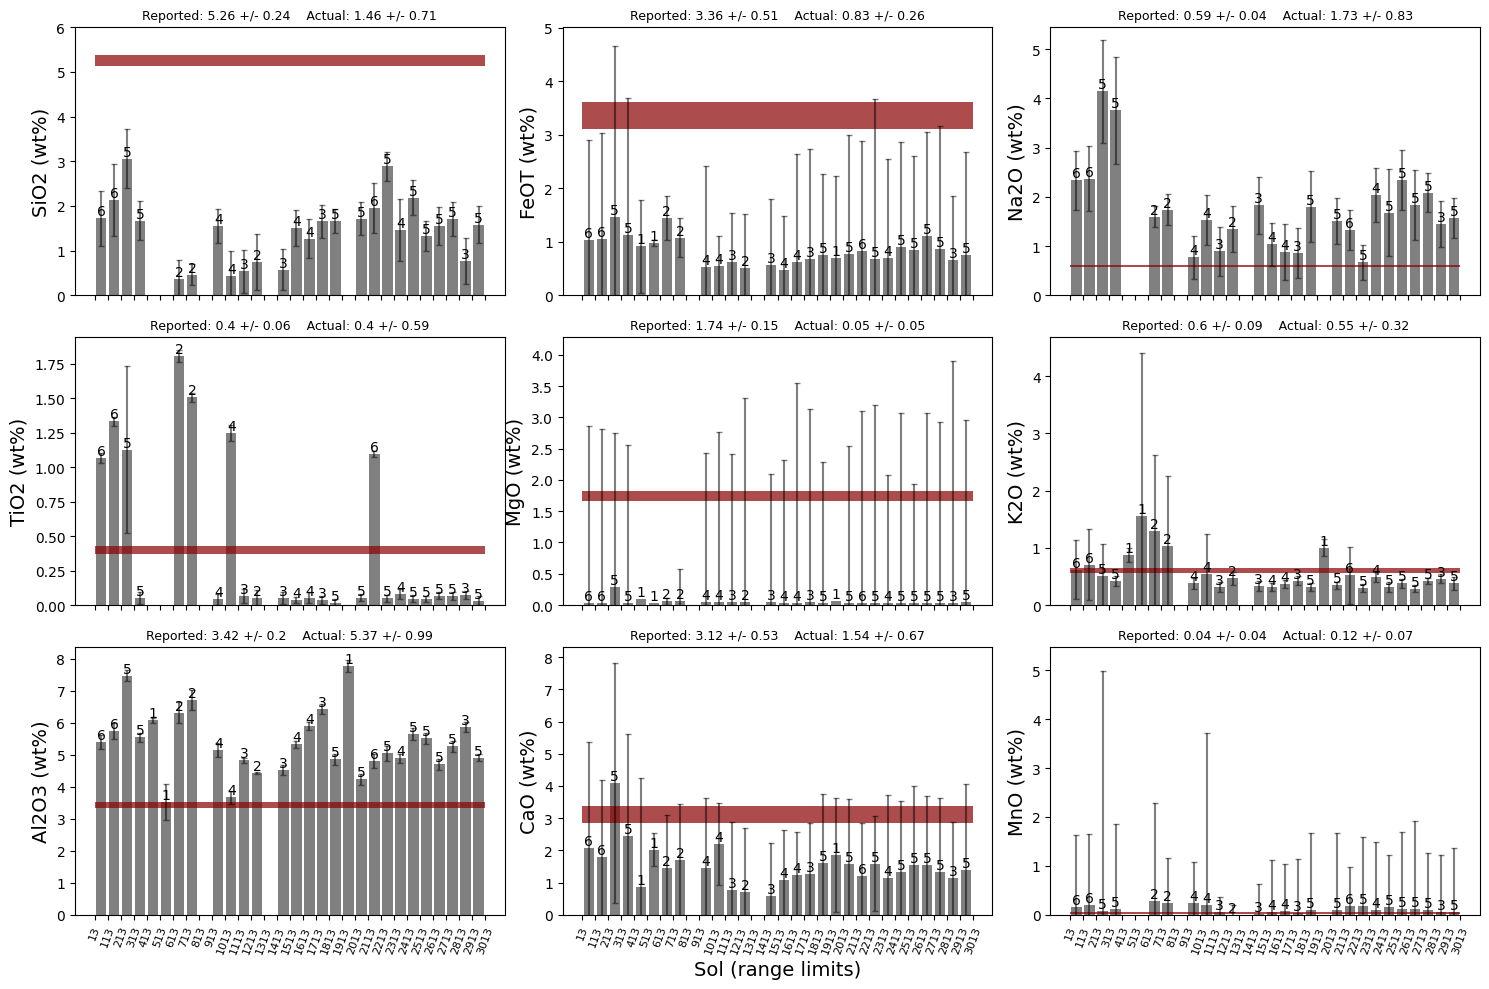

In [82]:
size = 10

x_labels = list(ranges)
x = np.arange(len(x_labels)-1)
x_ticks = xticks = [x-.5 for x in np.arange(len(x)+1)]

fig, ax = plt.subplots(nrows=3, 
                       ncols=3,
                       figsize = (15,10),
                       sharex=True)

x_ax = [0,1,2,0,1,2,0,1,2]
y_ax = [0,0,0,1,1,1,2,2,2]
i = 0
for oxide in comp_cols:
    
    # values
    yvals = rmse_summary[oxide+'_RMSE_mean']
    yerr = rmse_summary[oxide+'_RMSE_std']
    n_stds = rmse_summary['n_samples']
    avg_report = round(reported_rmse_dict[oxide]['avg'],2)
    avg_report_std = round(reported_rmse_dict[oxide]['std'],2)

    # reported RMSE box
    offset = avg_report_std/2
    origin = -.5
    y = avg_report - offset
    length = len(x)
    height = avg_report_std
    reported_errorbar = PatchCollection([Rectangle((origin, y), length, height)],
                                        edgecolor=None, facecolor='darkred', alpha=0.7)

    # actual error
    bar = ax[x_ax[i],y_ax[i]].bar(x, yvals, color='grey', zorder=0)
    
    # uncertainty
    ax[x_ax[i],y_ax[i]].errorbar(x, yvals, yerr=yerr, capsize=2, linestyle="", color='black', alpha=0.5)
    
    # number of standards
#    if i==0:
    ax[x_ax[i],y_ax[i]].bar_label(bar, n_stds)
    
    # reported error
    ax[x_ax[i],y_ax[i]].add_collection(reported_errorbar)
    
    ax[x_ax[i],y_ax[i]].set_title(f'Reported: {avg_report} +/- {avg_report_std}    Actual: {round(yvals.mean(),2)} +/- {round(yvals.std(),2)}',
                fontsize=size-1)
    
    # set axes
    ymin, ymax = ax[x_ax[i],y_ax[i]].get_ylim()
    ymin = 0
    ylimit = ceil(y+offset)
    if ymax < ylimit:
        ymax = ylimit
    ax[x_ax[i],y_ax[i]].set_ylim((ymin,ymax))
    
    # labels and ticks
    ax[x_ax[i],y_ax[i]].set_ylabel(f'{oxide} (wt%)', fontsize=size+4)
    ax[x_ax[i],y_ax[i]].set_xticks(x_ticks)
    ax[x_ax[i],y_ax[i]].set_xticklabels(labels=x_labels, fontsize=size-2, rotation=70)
    
    i+=1

#plt.annotate('Numbers above bars signify number of caltargets analysed during that time period',
#            (.1, .9), xycoords='figure fraction')
ax[2,1].set_xlabel('Sol (range limits)', fontsize=size+4)
plt.tight_layout()
plt.savefig('CCCT_rmsep_over_time_bar_plot.jpg', dpi=600)
plt.savefig('CCCT_rmsep_over_time_bar_plot.eps', dpi=600)
plt.show()

#### scatter plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

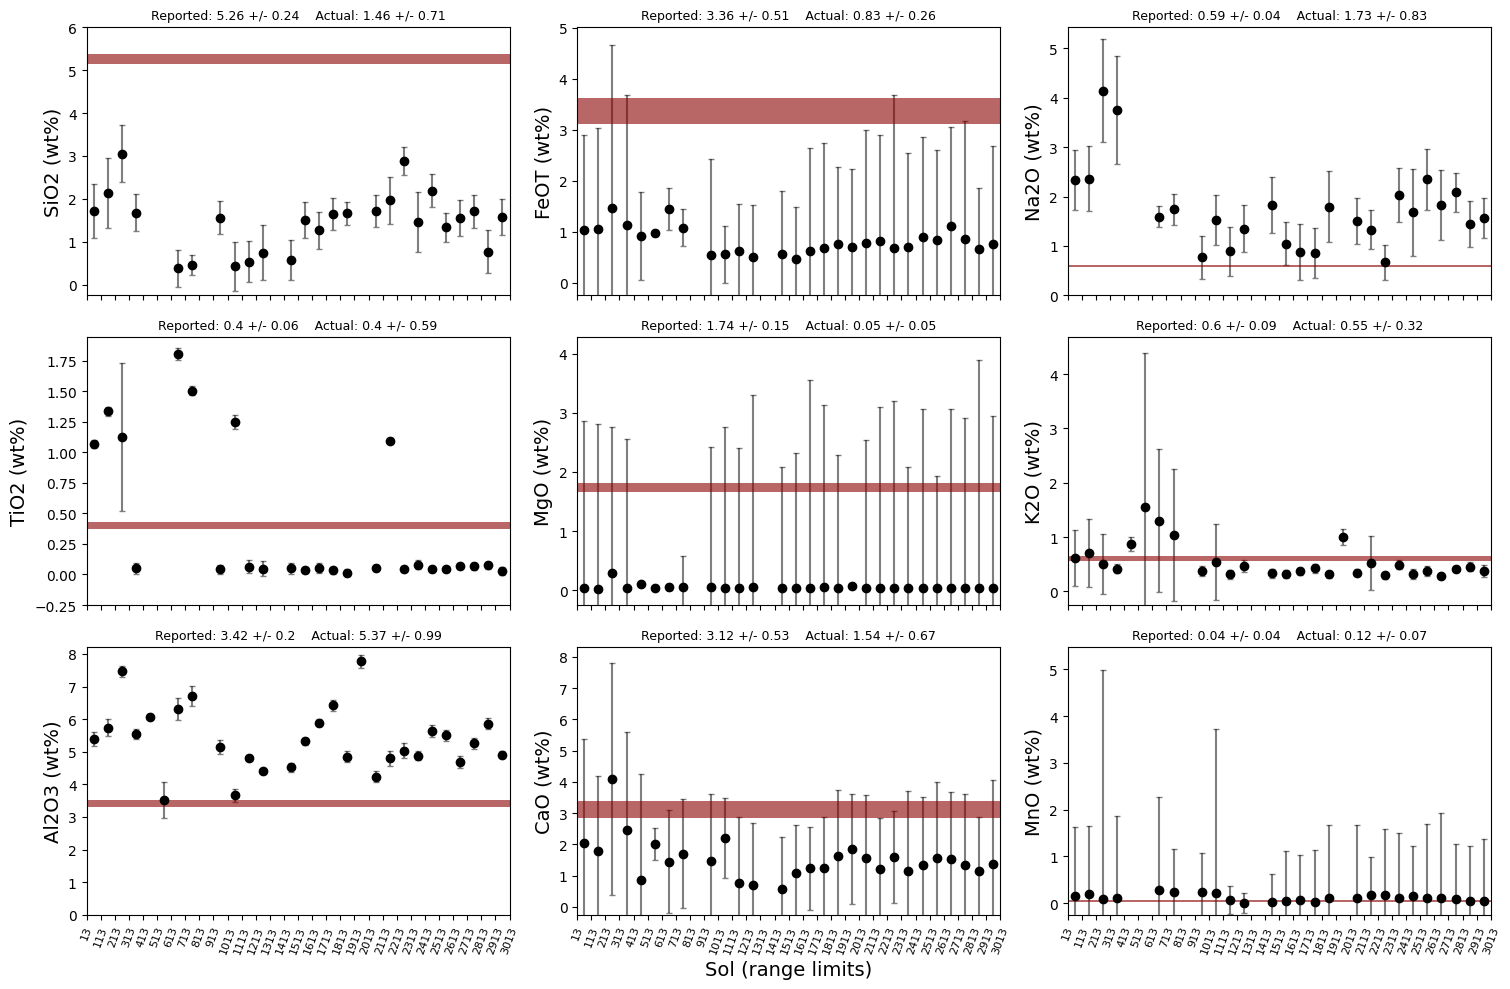

In [98]:
size = 10

x_labels = list(ranges)
x = np.arange(len(x_labels)-1)
x_ticks = xticks = [x-.5 for x in np.arange(len(x)+1)]

fig, ax = plt.subplots(nrows=3, 
                       ncols=3,
                       figsize = (15,10),
                       sharex=True)

x_ax = [0,1,2,0,1,2,0,1,2]
y_ax = [0,0,0,1,1,1,2,2,2]
i = 0
for oxide in comp_cols:
    
    # values
    yvals = rmse_summary[oxide+'_RMSE_mean']
    yerr = rmse_summary[oxide+'_RMSE_std']
    n_stds = rmse_summary['n_samples']
    avg_report = round(reported_rmse_dict[oxide]['avg'],2)
    avg_report_std = round(reported_rmse_dict[oxide]['std'],2)

    # reported RMSE box
    offset = avg_report_std/2
    origin = -.5
    y = avg_report - offset
    length = len(x)
    height = avg_report_std
    reported_errorbar = PatchCollection([Rectangle((origin, y), length, height)],
                                        edgecolor=None, facecolor='darkred', alpha=0.6)
    ax[x_ax[i],y_ax[i]].add_collection(reported_errorbar)

    # points
    ax[x_ax[i],y_ax[i]].scatter(x, yvals, color='black', edgecolor=None, zorder=2)
    
    # errorbar
    ax[x_ax[i],y_ax[i]].errorbar(x, yvals, yerr=yerr, capsize=2, linestyle="", color='black', alpha=0.5, zorder=0)
    ax[x_ax[i],y_ax[i]].set_xlim((0.5, 29.5))
    
    # set axes
    ymin, ymax = ax[x_ax[i],y_ax[i]].get_ylim()
    if ymin <0:
        ymin=-0.25
    else:
        ymin = 0
    ylimit = ceil(y+offset)
    if ymax < ylimit:
        ymax = ylimit
    ax[x_ax[i],y_ax[i]].set_ylim((ymin,ymax))
    
    # labels and ticks
    ax[x_ax[i],y_ax[i]].set_title(f'Reported: {avg_report} +/- {avg_report_std}    Actual: {round(yvals.mean(),2)} +/- {round(yvals.std(),2)}',
            fontsize=size-1)
    ax[x_ax[i],y_ax[i]].set_ylabel(f'{oxide} (wt%)', fontsize=size+4)
    ax[x_ax[i],y_ax[i]].set_xticks(x_ticks)
    ax[x_ax[i],y_ax[i]].set_xticklabels(labels=x_labels, fontsize=size-2, rotation=70)
    
    i+=1

#plt.annotate('Numbers above bars signify number of caltargets analysed during that time period',
#            (.1, .9), xycoords='figure fraction')
ax[2,1].set_xlabel('Sol (range limits)', fontsize=size+4)
plt.tight_layout()
plt.savefig('CCCT_rmsep_over_time_scatter_plot.jpg', dpi=600)
plt.savefig('CCCT_rmsep_over_time_scatter_plot.eps', dpi=600)
plt.show()

### shergottite over time
Instead do deviation plots like Ana did for thing? i.e subtract pred from actual and scale to 0

Lollipop chart off of actual

In [44]:
sherg = df[df.Target=='Shergottite'].copy()

sherg_mean = sherg.groupby('sol_range', as_index=False)[comp_cols].mean()
mean_cols = [c+'_mean' for c in comp_cols]
mean_cols.insert(0,'sol_range')
sherg_mean.columns = mean_cols

sherg_std = sherg.groupby('sol_range', as_index=False)[comp_cols].std()
std_cols = [c+'_std' for c in comp_cols]
std_cols.insert(0,'sol_range')
sherg_std.columns = std_cols

sherg_summary = sherg_mean.merge(sherg_std)

# add number of samples per group
n_analyses = sherg.groupby('sol_range', as_index=False).size()
n_analyses.rename(columns={'size':'n_analyses'}, inplace=True)
sherg_summary = n_analyses.merge(sherg_summary)

# add in empty ranges
empty_ranges = list(set(range_names) - set(sherg_summary.sol_range.unique()))
empty_range_df = pd.DataFrame([
    [empty_ranges[0], 0] + [np.nan]*len(sherg_summary.columns[2:]),
    [empty_ranges[1], 0] + [np.nan]*len(sherg_summary.columns[2:]),
    [empty_ranges[2], 0] + [np.nan]*len(sherg_summary.columns[2:])
],
    columns = sherg_summary.columns
)
sherg_summary = pd.concat([sherg_summary, empty_range_df])

# sort for plotting
sherg_summary['min_sol'] = [int(x.split('-')[0]) for x in sherg_summary.sol_range]
sherg_summary.sort_values('min_sol', ignore_index=True, inplace=True)

#### bar plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

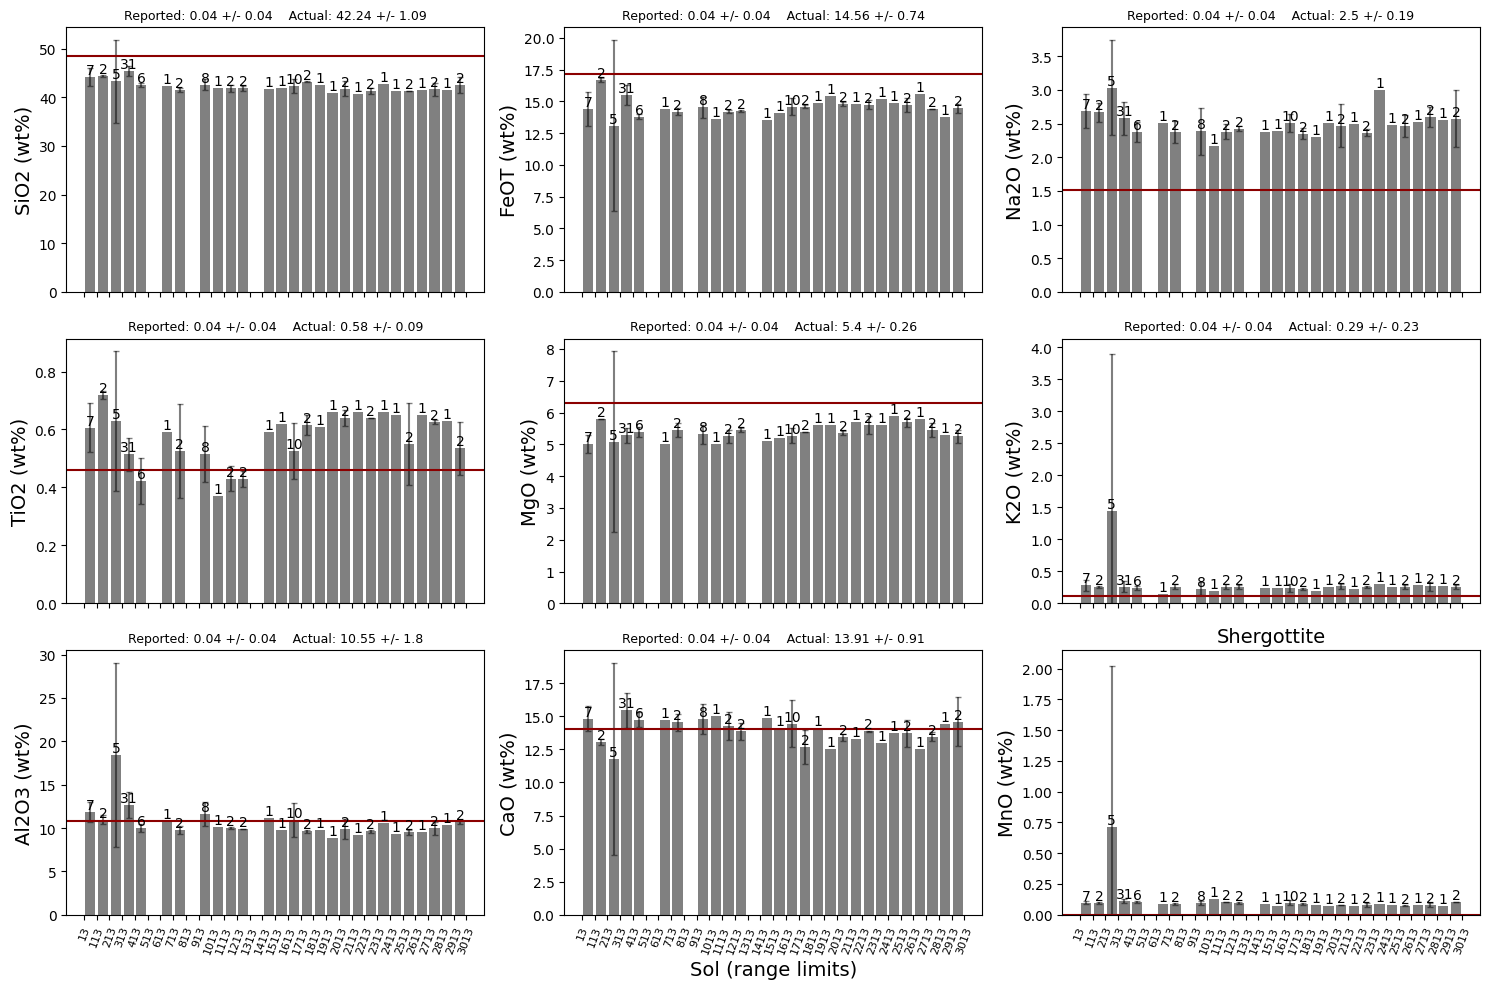

In [97]:
x_labels = list(ranges)
x = np.arange(len(x_labels)-1)
x_ticks = xticks = [x-.5 for x in np.arange(len(x)+1)]

fig, ax = plt.subplots(nrows=3, 
                       ncols=3,
                       figsize = (15,10),
                       sharex=True)

x_ax = [0,1,2,0,1,2,0,1,2]
y_ax = [0,0,0,1,1,1,2,2,2]
i = 0
for oxide in comp_cols:
    
    # values
    yvals = sherg_summary[oxide+'_mean']
    yerr = sherg_summary[oxide+'_std']
    n_stds = sherg_summary['n_analyses']
    actual = sherg[oxide+'_actual'].values[0]

    # actual error
    bar = ax[x_ax[i],y_ax[i]].bar(x, yvals, color='grey', zorder=0)
    
    # uncertainty
    ax[x_ax[i],y_ax[i]].errorbar(x, yvals, yerr=yerr, capsize=2, linestyle="", color='black', alpha=0.5)
    
    # number of standards
#    if i==0:
    ax[x_ax[i],y_ax[i]].bar_label(bar, n_stds)
    
    # reported error
    ax[x_ax[i],y_ax[i]].axhline(actual, color='darkred')
    ax[x_ax[i],y_ax[i]].set_title(f'Reported: {avg_report} +/- {avg_report_std}    Actual: {round(yvals.mean(),2)} +/- {round(yvals.std(),2)}',
                fontsize=size-1)
    
    # y limits
    ymin, ymax = ax[x_ax[i],y_ax[i]].get_ylim()
    ax[x_ax[i],y_ax[i]].set_ylim(0, ymax)
    
    # labels and ticks
    ax[x_ax[i],y_ax[i]].set_ylabel(f'{oxide} (wt%)', fontsize=size+4)
    ax[x_ax[i],y_ax[i]].set_xticks(x_ticks)
    ax[x_ax[i],y_ax[i]].set_xticklabels(labels=x_labels, fontsize=size-2, rotation=70)
    
    i+=1

#plt.annotate('Numbers above bars signify number of caltargets analysed during that time period',
#            (.1, .9), xycoords='figure fraction')
ax[2,1].set_xlabel('Sol (range limits)', fontsize=size+4)
plt.title('Shergottite', fontsize=size+4)
plt.tight_layout()
plt.savefig('shergottite_over_time_bar_plot.jpg', dpi=600)
plt.savefig('shergottite_over_time_bar_plot.eps', dpi=600)
plt.show()

#### lollipop chart

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

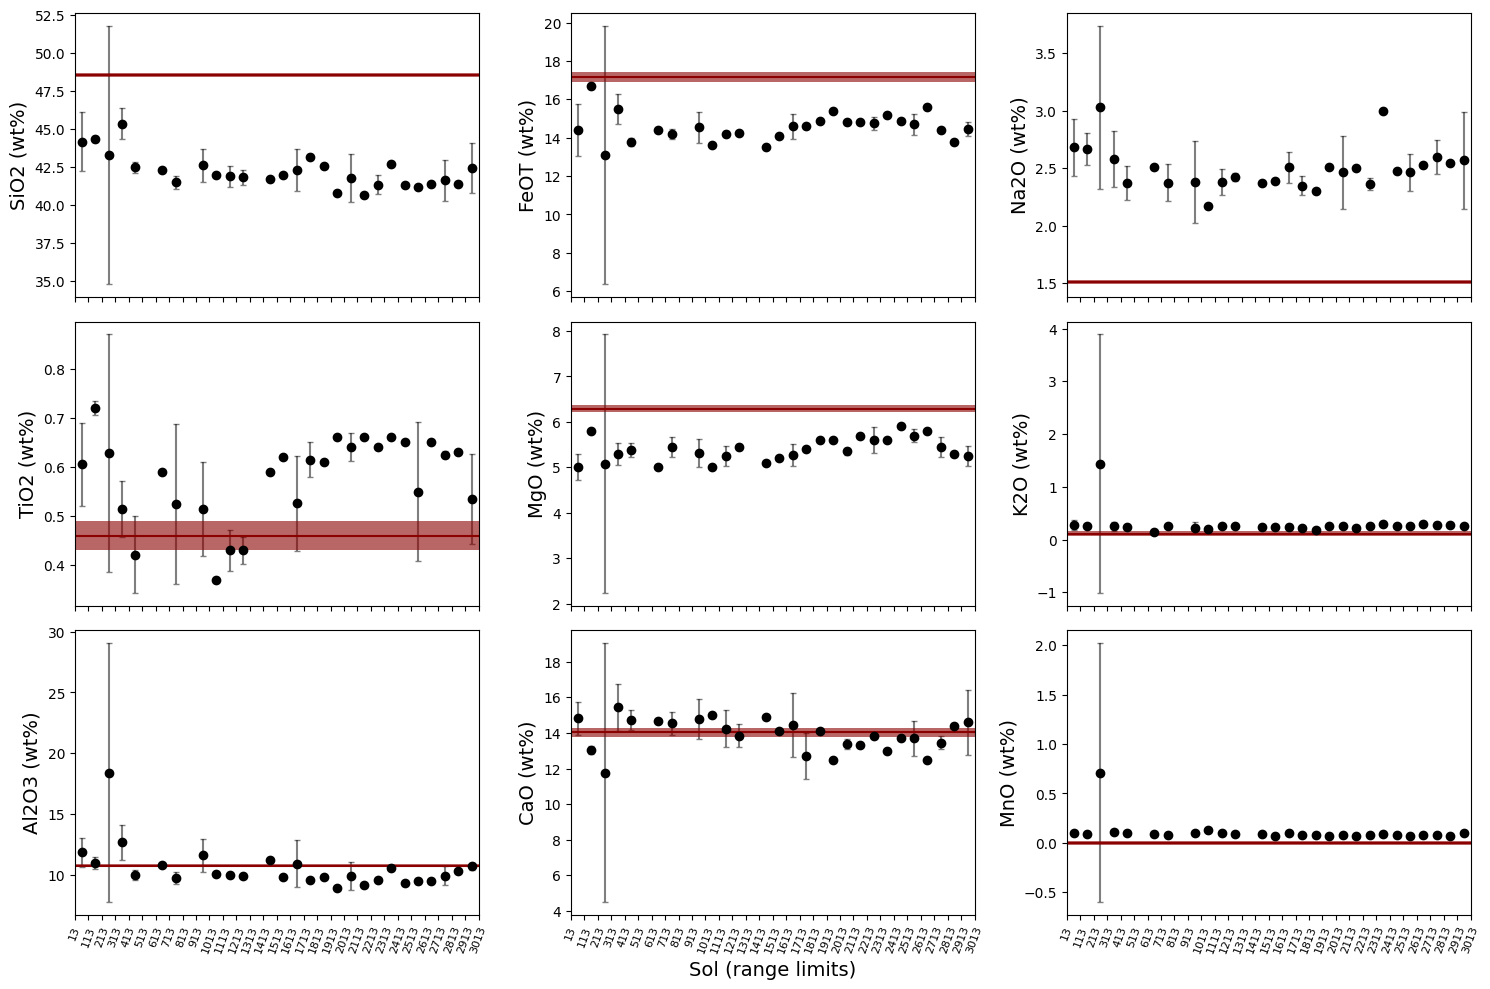

In [89]:
x_labels = list(ranges)
x = np.arange(len(x_labels)-1)
x_ticks = xticks = [x-.5 for x in np.arange(len(x)+1)]

fig, ax = plt.subplots(nrows=3, 
                       ncols=3,
                       figsize = (15,10),
                       sharex=True)

x_ax = [0,1,2,0,1,2,0,1,2]
y_ax = [0,0,0,1,1,1,2,2,2]
i = 0
for oxide in comp_cols:
    
    # values
    yvals = sherg_summary[oxide+'_mean']
    yerr = sherg_summary[oxide+'_std']
    n_stds = sherg_summary['n_analyses']
    actual = sherg[oxide+'_actual'].values[0]
    avg_report = round(reported_rmse_dict[oxide]['avg'],2)
    avg_report_std = round(reported_rmse_dict[oxide]['std'],2)
    
    # reported RMSE box
    offset = avg_report_std/2
    origin = -.5
    y = actual - offset
    length = len(x)+1
    height = avg_report_std
    reported_errorbar = PatchCollection([Rectangle((origin-.5, y), length, height)],
                                        edgecolor=None, facecolor='darkred', alpha=0.6)
    ax[x_ax[i],y_ax[i]].add_collection(reported_errorbar)

    # points
    ax[x_ax[i],y_ax[i]].scatter(x, yvals, color='black', edgecolor=None, zorder=2)
    
    # actual values
    ax[x_ax[i],y_ax[i]].axhline(actual, color='darkred', zorder=1)
    
    # errorbar
    ax[x_ax[i],y_ax[i]].errorbar(x, yvals, yerr=yerr, capsize=2, linestyle="", color='black', alpha=0.5, zorder=0)
    
    ax[x_ax[i],y_ax[i]].set_xlim((0.5, 29.5))
    
    # labels and ticks
    ax[x_ax[i],y_ax[i]].set_ylabel(f'{oxide} (wt%)', fontsize=size+4)
    ax[x_ax[i],y_ax[i]].set_xticks(x_ticks)
    ax[x_ax[i],y_ax[i]].set_xticklabels(labels=x_labels, fontsize=size-2, rotation=70)
    
    i+=1

#plt.annotate('Numbers above bars signify number of caltargets analysed during that time period',
#            (.1, .9), xycoords='figure fraction')
ax[2,1].set_xlabel('Sol (range limits)', fontsize=size+4)
plt.tight_layout()
plt.savefig('shergottite_over_time_scatter_plot.jpg', dpi=600)
plt.savefig('shergottite_over_time_scatter_plot.eps', dpi=600)
plt.show()